## Image Retrieval System


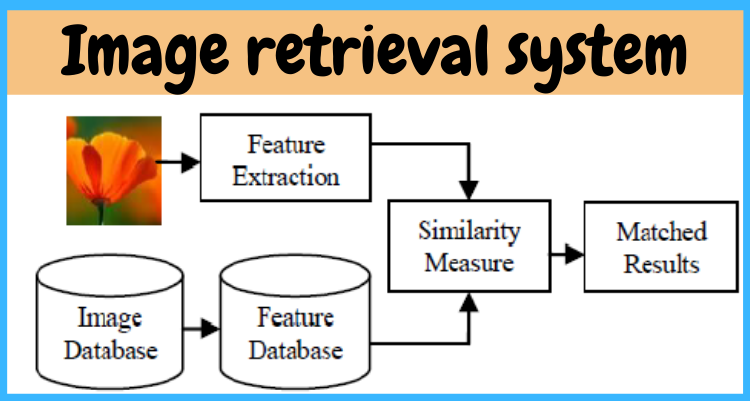
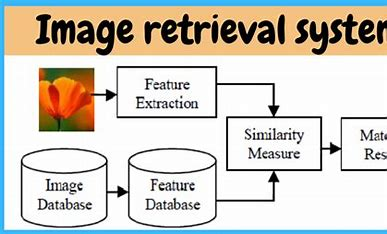

* `Importing Libraries`

In [1]:
import os 
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

* `Explore Data`

In [2]:
# Define the dataset path
FILEPATH = os.path.join(os.getcwd(), "..", "data")
img_path = os.path.join(FILEPATH, 'images')
images = os.listdir(img_path)

# List all classes (assuming each class is a folder)
classes = os.listdir(FILEPATH)
print("Classes:", classes)

Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'images']


c:\Users\YUSSEF\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


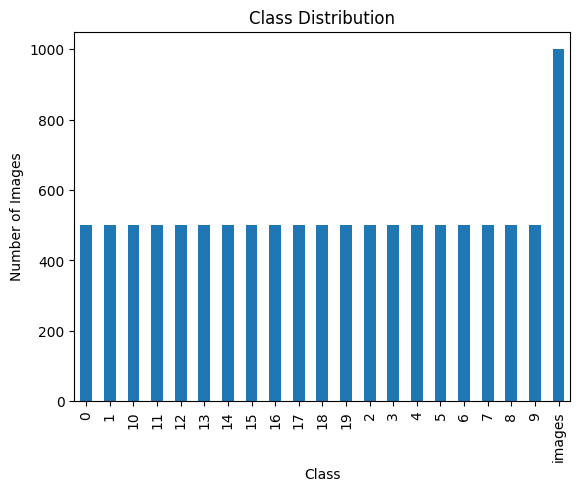

In [3]:
import pandas as pd

# Count images per class
class_counts = {}
for class_name in classes:
    class_dir = os.path.join(FILEPATH, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Visualize the distribution
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
df.head()

# Plot the distribution
df.plot(kind="bar", x="Class", y="Count", legend=False)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

The Distribution shows that the data is balanced 

Class: 0


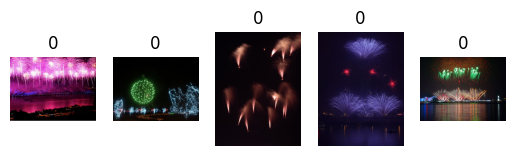

Class: 1


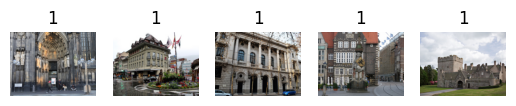

Class: 10


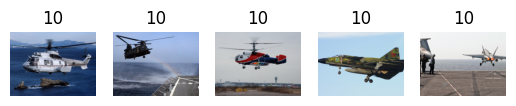

Class: 11


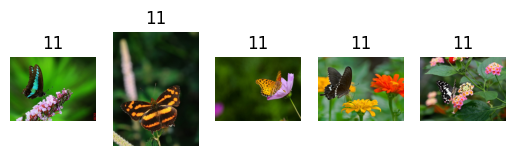

Class: 12


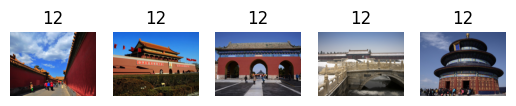

Class: 13


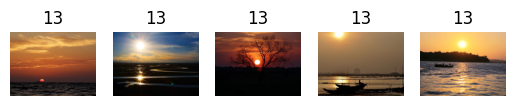

Class: 14


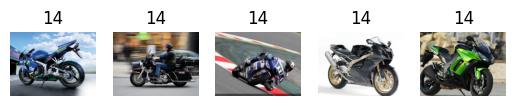

Class: 15


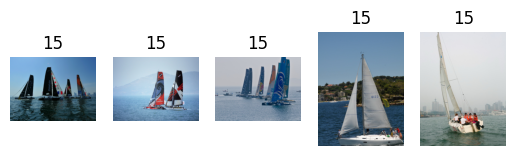

Class: 16


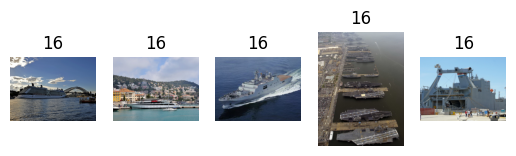

Class: 17


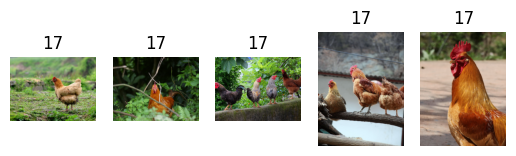

Class: 18


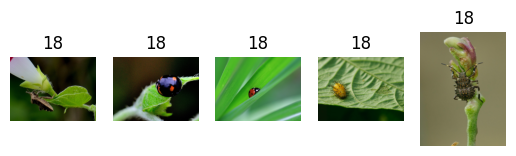

Class: 19


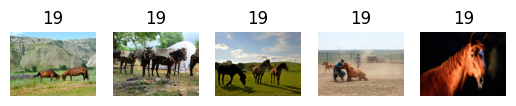

Class: 2


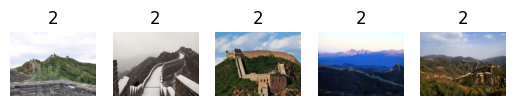

Class: 3


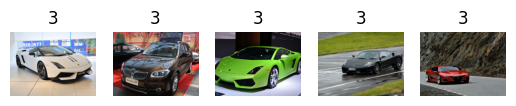

Class: 4


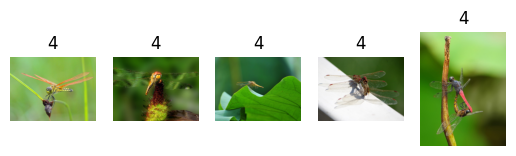

Class: 5


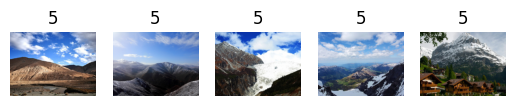

Class: 6


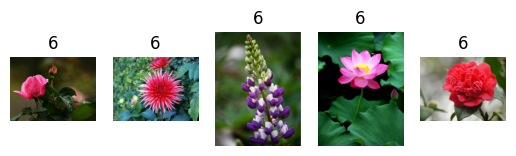

Class: 7


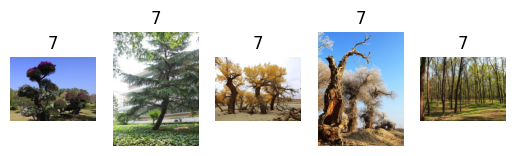

Class: 8


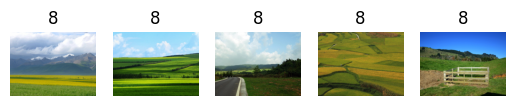

Class: 9


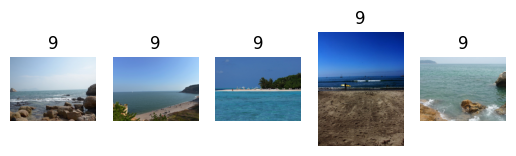

In [21]:
def visualize_samples(data_dir, num_samples=5):
    classes = os.listdir(data_dir)
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)
        print(f"Class: {class_name}")
        for i in range(num_samples):
            img_path = os.path.join(class_dir, random.choice(images))
            img = Image.open(img_path)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")
        plt.show()

visualize_samples(FILEPATH)

* `Intializing Model`

In [15]:
# Clear the cache and re-download the weights
import torch
import os
import shutil

# Clear PyTorch cache
cache_dir = os.path.expanduser('~/.cache/torch')
if os.path.exists(cache_dir):
    print(f"Clearing cache at {cache_dir}")
    shutil.rmtree(cache_dir)
    
# Try loading the model again
import torchvision
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()
preprocess

Clearing cache at C:\Users\YUSSEF/.cache/torch


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\YUSSEF/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:52<00:00, 1.95MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(1, 3, 256, 256), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 256, 256]     [1, 1000]            --                   True
├─Conv2d (conv1)                         [1, 3, 256, 256]     [1, 64, 128, 128]    9,408                True
├─BatchNorm2d (bn1)                      [1, 64, 128, 128]    [1, 64, 128, 128]    128                  True
├─ReLU (relu)                            [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 128, 128]    [1, 64, 64, 64]      --                   --
├─Sequential (layer1)                    [1, 64, 64, 64]      [1, 256, 64, 64]     --                   True
│    └─Bottleneck (0)                    [1, 64, 64, 64]      [1, 256, 64, 64]     --                   True
│    │    └─Conv2d (conv1)               [1, 64, 64, 64]      [1, 64, 64, 64]      4,096                True
│    │    └─BatchN

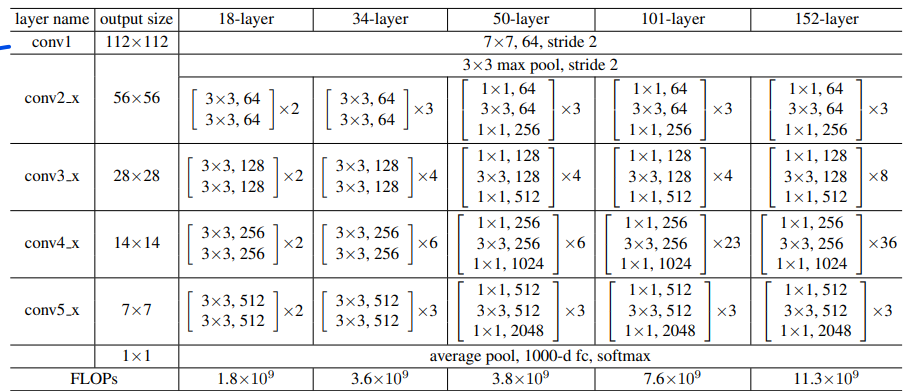

In [17]:
activation = {}
def get_activation(name):
    def hook(model , input , output): #The hook() function will be called automatically by PyTorch whenever the layer specified by name produces an output during the forward pass.
        activation[name] = output.detach()
    return hook

model.avgpool.register_forward_hook(get_activation("avgpool"))

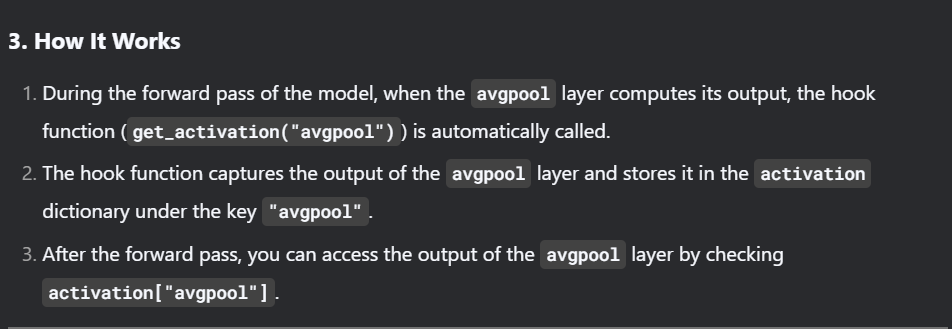

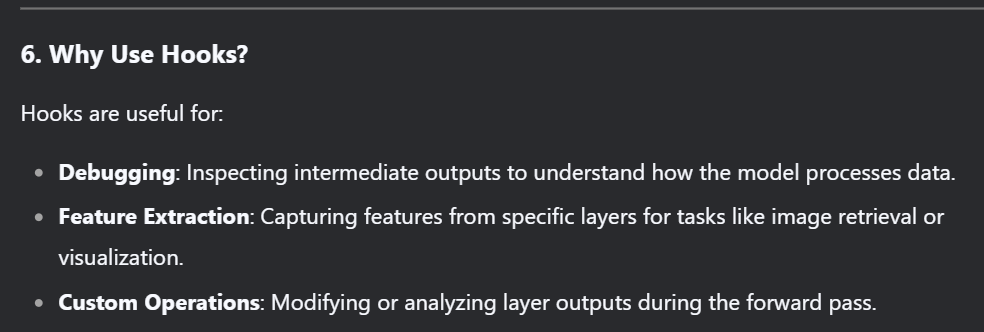

In [18]:
## test the hook function
input_tensor = torch.randn(1, 3, 224, 224)

# perform the forward pass
output = model(input_tensor)

# Access the captured activation
avgpool_output = activation["avgpool"]
print("AvgPool Output Shape:", avgpool_output.shape)
activation.keys()

AvgPool Output Shape: torch.Size([1, 2048, 1, 1])


dict_keys(['avgpool'])

* `Extracting Features`

In [19]:
all_names = []
all_vecs = None
with torch.no_grad():
    for i, file in enumerate(images):
        try:
            path = os.path.join(img_path , file)
            img = Image.open(path)  
            img = preprocess(img) # Shape: [C, H, W]
            out = model(img[None , ...]) # Shape: [1, C, H, W] = unsqueeze(0)
            vec = activation["avgpool"].numpy().squeeze()[None , ...]

            if all_vecs is None: # in the begging only
                all_vecs = vec
            else:
                all_vecs = np.vstack([all_vecs , vec])
            all_names.append(file)
        except:
            continue
        
        if i % 100 == 0 and i != 0:
            print(i , "done")


100 done
200 done
600 done
700 done
800 done
900 done


In [20]:
import pandas as pd
pd.DataFrame(all_vecs)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,0.000000,0.069195,0.000000,0.000000,0.000000,0.778292,0.000000,0.264362,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005406,0.084098
1,0.000000,0.005865,0.000000,0.006425,0.006773,0.179606,0.281896,0.026785,0.315234,0.000000,...,0.008772,0.000000,0.0,0.012808,0.000000,0.000000,0.000000,0.000000,0.000000,0.023249
2,0.000000,0.000000,0.037100,0.000000,0.095826,0.000000,0.006958,0.000000,0.144660,0.040774,...,0.000000,0.000000,0.0,0.058630,0.000000,0.000000,0.022304,0.000000,0.000000,0.063572
3,0.000000,0.000000,0.007358,0.000000,0.000000,0.000000,0.075936,0.000000,0.065073,0.000000,...,0.000000,0.002123,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019679,0.000000,0.120776,0.000000,...,0.000000,0.000636,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.016211,0.000000,0.209735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010305,0.000000,0.0,0.000000,0.105318,0.000027,0.048309,0.022722,0.031511,0.000000
696,0.000000,0.000000,0.063600,0.000000,0.009039,0.000000,0.603346,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.019867,0.000000,0.000000,0.000000,0.003754,0.000000
697,0.000000,0.000000,0.044246,0.000000,0.000000,0.133861,0.173256,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.040154,0.000000,0.000000,0.000000,0.000000,0.000000
698,0.083552,0.029306,0.249505,0.003952,0.000000,0.000000,0.000052,0.000000,0.000000,0.000000,...,0.000000,0.105563,0.0,0.000000,0.007990,0.026120,0.006026,0.002306,0.000000,0.008956


In [22]:
np.save("all_vecs.npy" , all_vecs)
np.save("all_names.npy" , all_names)